## 1 Dataset

In [1]:
import numpy as np
import tensorflow as tf
import scipy.io
import tensorly as ts
import os
import matplotlib.pyplot as plt
os.chdir("G:/jupyter/Guangzhou-data-set")
tensor = scipy.io.loadmat('tensor.mat')
tensor = tensor['tensor']
tensor = np.array(tensor)
print(tensor.shape)
tensor = tensor.reshape(214,-1)
print(tensor.shape)

Using numpy backend.


(214, 61, 144)
(214, 8784)


## 2 Produce spatial matrix $W$ with part of data through matrix factorization

### 2.1 Determine the data for producing $W$

In [64]:
tensor_1 = tensor[:,:8784-144*5]

missing_rate = 0.4
condition = np.random.binomial(1, 1-missing_rate, np.shape(tensor_1)[0]*np.shape(tensor_1)[1])
condition = np.reshape(condition,(np.shape(tensor_1)[0],np.shape(tensor_1)[1]))
mask = np.where(condition<1,0.,1.)

print(mask.shape)
sparse_tensor1 = np.multiply(tensor_1, mask)

print(sparse_tensor1.shape)

mean = (np.sum(sparse_tensor1)*1.0/np.sum(mask))
init_tensor = sparse_tensor1
init_tensor[init_tensor==0] = mean
print(init_tensor.shape)


(214, 8064)
(214, 8064)
(214, 8064)


In [65]:
condition.shape

(214, 8064)

### 2.2 Set matrix factorization procedure

In [120]:
dim = tensor_1.shape
rank1 = 200 # feature dim of spatial matrix

tf.reset_default_graph()

init_tensor_holder = tf.placeholder(tf.float32, shape=[dim[0], dim[1]]) 
sparse_tensor_holder = tf.placeholder(tf.float32, shape=[dim[0], dim[1]])    
tensor_holder = tf.placeholder(tf.float32, shape=[dim[0], dim[1]])  
mask_tensor_holder =  tf.placeholder(tf.float32, shape=[dim[0], dim[1]])

su, w, x = tf.svd(init_tensor_holder)

w_ = w[:,0:rank1]
x_ = tf.transpose(x[:,0:rank1])

# initialzation through SVD scheme
sess = tf.Session()
W_, X_ = sess.run([w_,x_], feed_dict={init_tensor_holder:init_tensor})

W = tf.Variable(W_)
X = tf.Variable(X_)

Train_Param=[W,X]

impute_tensor = tf.matmul(W, X)

# loss function
loss = tf.reduce_mean((mask_tensor_holder * tensor_holder - mask_tensor_holder * impute_tensor) ** 2)
loss_evaluation = tf.reduce_sum(( (1.-mask_tensor_holder)*tensor_holder - (1.-mask_tensor_holder) * impute_tensor)  ** 2) / (tf.math.reduce_sum(1.-mask_tensor_holder))
loss_all = tf.reduce_mean((tensor_holder - impute_tensor) ** 2)
solver = tf.train.AdamOptimizer(0.008).minimize(loss, var_list=Train_Param)

### 2.3 Run for spatial matrix production

In [121]:
sess.run(tf.global_variables_initializer())
W_base_temp=np.zeros([dim[0],rank1])
X_predict_target_temp = np.zeros([rank1,dim[1]])
W_var = []
X_var = []
loss_mf = []

for i in range(4500):
    _, _, it = sess.run([solver, loss, impute_tensor], feed_dict = 
                           {mask_tensor_holder: mask, sparse_tensor_holder: sparse_tensor1, 
                            tensor_holder:tensor_1})
    if i % 10==0:
        imputation_result, loss_eval, loss_train,loss_all_, W_base, X_predict_target = sess.run([impute_tensor,loss_evaluation,loss,loss_all,W, X], feed_dict =
                                     {mask_tensor_holder: mask, sparse_tensor_holder: sparse_tensor1, 
                                      tensor_holder:tensor_1})
        
        print('epoch = {:}'.format(i))
        print('TRAIN RMSE = {:.6}'.format(np.sqrt(loss_train)))
        print('TEST RMSE = {:.6}'.format(np.sqrt(loss_eval)))
        print('Overall RMSE = {:.6}'.format(np.sqrt(loss_all_)))
        print('-------------------------------------------------')

        W_var.append(float(sum(sum((abs(W_base-W_base_temp))))))
        X_var.append(float(sum(sum((abs(X_predict_target-X_predict_target_temp))))))
        loss_mf.append(loss_train)
        
    W_base_temp=W_base
    X_predict_target_temp = X_predict_target

epoch = 0
TRAIN RMSE = 31.1761
TEST RMSE = 40.2643
Overall RMSE = 40.2597
-------------------------------------------------
epoch = 10
TRAIN RMSE = 30.6559
TEST RMSE = 39.6552
Overall RMSE = 39.6131
-------------------------------------------------
epoch = 20
TRAIN RMSE = 28.1261
TEST RMSE = 36.3983
Overall RMSE = 36.351
-------------------------------------------------
epoch = 30
TRAIN RMSE = 22.6975
TEST RMSE = 29.3952
Overall RMSE = 29.3432
-------------------------------------------------
epoch = 40
TRAIN RMSE = 14.6379
TEST RMSE = 18.9963
Overall RMSE = 18.9393
-------------------------------------------------
epoch = 50
TRAIN RMSE = 7.78003
TEST RMSE = 10.1307
Overall RMSE = 10.0798
-------------------------------------------------
epoch = 60
TRAIN RMSE = 6.38747
TEST RMSE = 8.28573
Overall RMSE = 8.26293
-------------------------------------------------
epoch = 70
TRAIN RMSE = 5.14961
TEST RMSE = 6.70304
Overall RMSE = 6.67084
-------------------------------------------------
ep

epoch = 660
TRAIN RMSE = 2.68651
TEST RMSE = 4.43915
Overall RMSE = 3.88635
-------------------------------------------------
epoch = 670
TRAIN RMSE = 2.64935
TEST RMSE = 4.42657
Overall RMSE = 3.85498
-------------------------------------------------
epoch = 680
TRAIN RMSE = 2.61196
TEST RMSE = 4.41464
Overall RMSE = 3.82384
-------------------------------------------------
epoch = 690
TRAIN RMSE = 2.57431
TEST RMSE = 4.40332
Overall RMSE = 3.79298
-------------------------------------------------
epoch = 700
TRAIN RMSE = 2.53645
TEST RMSE = 4.39259
Overall RMSE = 3.76235
-------------------------------------------------
epoch = 710
TRAIN RMSE = 2.49835
TEST RMSE = 4.38242
Overall RMSE = 3.73201
-------------------------------------------------
epoch = 720
TRAIN RMSE = 2.46007
TEST RMSE = 4.37279
Overall RMSE = 3.70193
-------------------------------------------------
epoch = 730
TRAIN RMSE = 2.42161
TEST RMSE = 4.36368
Overall RMSE = 3.67215
------------------------------------------

epoch = 1310
TRAIN RMSE = 0.692096
TEST RMSE = 4.25668
Overall RMSE = 2.78028
-------------------------------------------------
epoch = 1320
TRAIN RMSE = 0.677076
TEST RMSE = 4.25747
Overall RMSE = 2.77706
-------------------------------------------------
epoch = 1330
TRAIN RMSE = 0.662521
TEST RMSE = 4.25828
Overall RMSE = 2.77404
-------------------------------------------------
epoch = 1340
TRAIN RMSE = 0.64842
TEST RMSE = 4.2591
Overall RMSE = 2.7712
-------------------------------------------------
epoch = 1350
TRAIN RMSE = 0.634765
TEST RMSE = 4.25994
Overall RMSE = 2.76855
-------------------------------------------------
epoch = 1360
TRAIN RMSE = 0.621547
TEST RMSE = 4.26079
Overall RMSE = 2.76607
-------------------------------------------------
epoch = 1370
TRAIN RMSE = 0.608753
TEST RMSE = 4.26166
Overall RMSE = 2.76375
-------------------------------------------------
epoch = 1380
TRAIN RMSE = 0.596378
TEST RMSE = 4.26255
Overall RMSE = 2.7616
------------------------------

epoch = 1960
TRAIN RMSE = 0.271972
TEST RMSE = 4.33004
Overall RMSE = 2.75241
-------------------------------------------------
epoch = 1970
TRAIN RMSE = 0.269339
TEST RMSE = 4.33139
Overall RMSE = 2.75301
-------------------------------------------------
epoch = 1980
TRAIN RMSE = 0.266737
TEST RMSE = 4.33275
Overall RMSE = 2.75361
-------------------------------------------------
epoch = 1990
TRAIN RMSE = 0.264164
TEST RMSE = 4.33411
Overall RMSE = 2.75422
-------------------------------------------------
epoch = 2000
TRAIN RMSE = 0.261619
TEST RMSE = 4.33547
Overall RMSE = 2.75483
-------------------------------------------------
epoch = 2010
TRAIN RMSE = 0.2591
TEST RMSE = 4.33684
Overall RMSE = 2.75545
-------------------------------------------------
epoch = 2020
TRAIN RMSE = 0.256607
TEST RMSE = 4.3382
Overall RMSE = 2.75608
-------------------------------------------------
epoch = 2030
TRAIN RMSE = 0.254139
TEST RMSE = 4.33958
Overall RMSE = 2.75672
-----------------------------

epoch = 2610
TRAIN RMSE = 0.139468
TEST RMSE = 4.41851
Overall RMSE = 2.79847
-------------------------------------------------
epoch = 2620
TRAIN RMSE = 0.137882
TEST RMSE = 4.41977
Overall RMSE = 2.79919
-------------------------------------------------
epoch = 2630
TRAIN RMSE = 0.136308
TEST RMSE = 4.42102
Overall RMSE = 2.7999
-------------------------------------------------
epoch = 2640
TRAIN RMSE = 0.134746
TEST RMSE = 4.42227
Overall RMSE = 2.80061
-------------------------------------------------
epoch = 2650
TRAIN RMSE = 0.133196
TEST RMSE = 4.42351
Overall RMSE = 2.80132
-------------------------------------------------
epoch = 2660
TRAIN RMSE = 0.131658
TEST RMSE = 4.42474
Overall RMSE = 2.80203
-------------------------------------------------
epoch = 2670
TRAIN RMSE = 0.130131
TEST RMSE = 4.42596
Overall RMSE = 2.80273
-------------------------------------------------
epoch = 2680
TRAIN RMSE = 0.128616
TEST RMSE = 4.42718
Overall RMSE = 2.80344
---------------------------

epoch = 3250
TRAIN RMSE = 0.061158
TEST RMSE = 4.48355
Overall RMSE = 2.83697
-------------------------------------------------
epoch = 3260
TRAIN RMSE = 0.0602926
TEST RMSE = 4.48429
Overall RMSE = 2.83743
-------------------------------------------------
epoch = 3270
TRAIN RMSE = 0.0594371
TEST RMSE = 4.48502
Overall RMSE = 2.83787
-------------------------------------------------
epoch = 3280
TRAIN RMSE = 0.0585918
TEST RMSE = 4.48574
Overall RMSE = 2.83832
-------------------------------------------------
epoch = 3290
TRAIN RMSE = 0.0577564
TEST RMSE = 4.48645
Overall RMSE = 2.83875
-------------------------------------------------
epoch = 3300
TRAIN RMSE = 0.056931
TEST RMSE = 4.48716
Overall RMSE = 2.83918
-------------------------------------------------
epoch = 3310
TRAIN RMSE = 0.0561155
TEST RMSE = 4.48785
Overall RMSE = 2.83961
-------------------------------------------------
epoch = 3320
TRAIN RMSE = 0.0553099
TEST RMSE = 4.48854
Overall RMSE = 2.84003
--------------------

epoch = 3890
TRAIN RMSE = 0.0231119
TEST RMSE = 4.51552
Overall RMSE = 2.85679
-------------------------------------------------
epoch = 3900
TRAIN RMSE = 0.0227435
TEST RMSE = 4.51582
Overall RMSE = 2.85697
-------------------------------------------------
epoch = 3910
TRAIN RMSE = 0.0223804
TEST RMSE = 4.51611
Overall RMSE = 2.85715
-------------------------------------------------
epoch = 3920
TRAIN RMSE = 0.0220226
TEST RMSE = 4.51639
Overall RMSE = 2.85733
-------------------------------------------------
epoch = 3930
TRAIN RMSE = 0.02167
TEST RMSE = 4.51667
Overall RMSE = 2.8575
-------------------------------------------------
epoch = 3940
TRAIN RMSE = 0.0213224
TEST RMSE = 4.51695
Overall RMSE = 2.85768
-------------------------------------------------
epoch = 3950
TRAIN RMSE = 0.0209799
TEST RMSE = 4.51722
Overall RMSE = 2.85785
-------------------------------------------------
epoch = 3960
TRAIN RMSE = 0.0206424
TEST RMSE = 4.51748
Overall RMSE = 2.85801
---------------------

In [141]:
min(W_var)

0.4407699342118576

4.526457


<function matplotlib.pyplot.show(*args, **kw)>

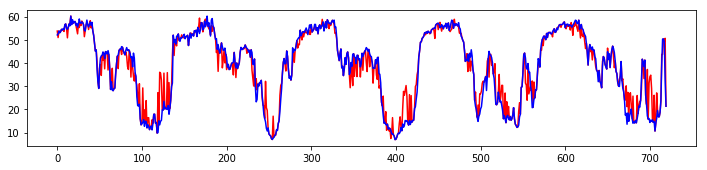

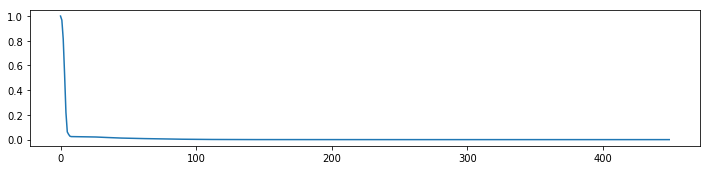

In [123]:
Y = np.matmul(W_base,X_predict_target)
plt.figure(figsize = (12, 2.5))
plt.plot(Y[93,-144*5:],'r')
plt.plot(tensor_1[93,-144*5:],'b')
plt.show
print(np.sqrt(loss_eval))
plt.figure(figsize = (12, 2.5))
loss_mf_norm = [s/max(loss_mf) for s in loss_mf]
# plt.plot(W_var,'r')
# plt.plot(X_var,'b')
plt.plot(loss_mf_norm)
plt.show

## 3. MF based LSTM traffic prediction scheme

### 3.1 Sample production (feature prediction scheme)

In [165]:
input_horizon = 3
pred_horizon = 1
network_size = 214
sampleset = []
field_predict_set=[]
for i in range(tensor_1.shape[1]-input_horizon-pred_horizon):
    sample = []
    field_predict = []
    j = i
    while j-i < input_horizon:
        sample+=X_predict_target[:,j].tolist()[:]
        j+=1
    while j-i-input_horizon < pred_horizon:
        sample+=X_predict_target[:,j].tolist()[:]
        field_predict+=tensor_1[:,j].tolist()[:]
        j+=1
    sampleset.append(sample)
    field_predict_set.append(field_predict)

print('Sample num: %d'%len(sampleset))

def generateBatch(samples,fieldset,epoch,input_horizon=input_horizon,feature_len=rank1,batchsize=32, istrain=True):
    xbatchset=[]
    ybatchset=[]
    speedset=[]
    for i in range(batchsize):
        if istrain:
            index = epoch*batchsize+i
            xbatchset.append(samples[index][:input_horizon*feature_len])
            ybatchset.append(samples[index][input_horizon*feature_len:])
            speedset.append(fieldset[index])
    return xbatchset,ybatchset,speedset

Sample num: 8060


### 3.2 Basic LSTM model

In [166]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.5)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.02, shape=shape)
    return initial

class Model():
    def __init__(self,input_horizon, predict_horizon, networksize, feature_len):
        self.input_horizon = input_horizon
        self.predict_horizon = predict_horizon
        self.networksize = networksize
        self.feature_len = feature_len
        self.bottom = tf.placeholder(tf.float32, shape=[None, self.input_horizon*self.feature_len], name='input')  
        self.target = tf.placeholder(tf.float32, shape=[None, self.predict_horizon*self.feature_len], name='target')
#         self.onestepfeature = tf.placeholder(tf.float32, shape=[None, self.feature_len], name='feature')
        self.spatialmatrix = tf.placeholder(tf.float32, shape=[self.networksize, self.feature_len], name='spatial')
        self.field = tf.placeholder(tf.float32, shape=[None, self.predict_horizon*self.networksize], name='field_speed')
        
    def build_LSTM(self,num_layers=1,batch_size=16,rnn_size=128): # rnn_size : output_size
        bottom = tf.reshape(self.bottom, [-1, self.feature_len])
        W_input = weight_variable([self.feature_len, 128])
        b_input = bias_variable([128])
        input_ = tf.nn.elu(tf.matmul(bottom, W_input) + b_input)
        input_ = tf.reshape(input_, [-1, self.input_horizon, 128])

        self.cell = tf.contrib.rnn.BasicLSTMCell(rnn_size, state_is_tuple=True)
        self.cell = tf.contrib.rnn.MultiRNNCell([self.cell] * num_layers, state_is_tuple=True)

        outputs, last_state = tf.nn.dynamic_rnn(self.cell, input_, dtype=tf.float32)
        output_last_step = outputs[:,-1,:]

        W_output = weight_variable([rnn_size, self.predict_horizon*self.feature_len])
        b_output = bias_variable([self.predict_horizon*self.feature_len])
        self.predict = tf.nn.tanh(tf.matmul(output_last_step, W_output)+b_output)+self.bottom[:,-self.feature_len:]
        
        global_step = tf.Variable(0, trainable=False)
        
        W_w = weight_variable([self.networksize,self.feature_len])
#         b_w = bias_variable([self.input_horizon*self.feature_len])
        
        self.learning_rate = 0.0002
        
        self.recover = tf.matmul(self.predict,tf.transpose(self.spatialmatrix) )#tf.transpose(W_w))
        
        self.field_loss = tf.reduce_mean(tf.squared_difference(self.recover, self.field))
        self.loss = tf.reduce_mean(tf.squared_difference(self.target, self.predict))
        self.accuracy = 1. - tf.reduce_mean(abs(self.target-self.predict)/self.target)
        
#         self.field_loss = tf.reduce_mean(tf.squared_difference(self.recover, self.field))+tf.reduce_mean(tf.squared_difference(W_w,self.spatialmatrix))
        
        self.costumloss = self.field_loss #+tf.reduce_mean(tf.squared_difference(W_w,self.spatialmatrix))
        
        self.trainop = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss, global_step=global_step)
        
        
        

### 3.3 Train procedure

#### 3.3.1 Set up for experiment

In [167]:
tf.reset_default_graph()
sess = tf.Session()

model = Model(input_horizon=input_horizon, predict_horizon=pred_horizon, networksize=network_size, feature_len=rank1)
model.build_LSTM()

# saver = tf.train.Saver(tf.global_variables())
#     checkpoint = tf.train.latest_checkpoint('/home/administrator/pywork/DeepLearningXC/trainingDir/logs_l_45min_5min')




In [168]:
# parameter initialization
init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
sess.run(init_op)
saver = tf.train.Saver()

#### 3.3.2 Train model

In [170]:
end = 8748-144*5
trainset = sampleset[0:end]
train_field_predict_set = field_predict_set[0:end]

testset = sampleset[end:]
test_field_predict_set = field_predict_set[end:]

train_epochs = 2
batch_size = 16

for epoch in range(train_epochs):
    eploss = []
    train_field_loss = []
    for ep in range(int(len(trainset)/batch_size-1)):
        x_batch, y_batch, field_batch = generateBatch(trainset,train_field_predict_set,batchsize=batch_size, epoch=ep)
        _, loss_, acc_train, pred_result,field_loss_ = sess.run([model.trainop, model.loss, model.accuracy,model.predict,model.costumloss],
                                       feed_dict={model.bottom: x_batch, model.target: y_batch, model.spatialmatrix:W_base,model.field:field_batch})
        
        eploss.append(loss_)
        train_field_loss.append(field_loss_)
        
    x_batch, y_batch, field_batch = generateBatch(testset, test_field_predict_set, batchsize=len(testset), epoch=0)
    
    loss_, acc_train, pred_result,costumloss,field_loss_ = sess.run([model.loss, model.accuracy,model.predict, model.costumloss, model.field_loss],
                                       feed_dict={model.bottom: x_batch, model.target: y_batch, model.spatialmatrix:W_base, model.field:field_batch})
    
    print('Epoch:%d Train loss: %g # Train field loss: %g | Test loss: %g # Testcostumloss loss:%g # Test field loss:%g'%(epoch,float(sum(eploss)/len(eploss)),np.sqrt(float(sum(train_field_loss)/len(train_field_loss))), loss_, np.sqrt(costumloss),np.sqrt(field_loss_)))
save_path = saver.save(sess, "G:/jupyter/tmp/model.ckpt")
    

Epoch:0 Train loss: 0.277222 # Train field loss: 3.79796 | Test loss: 0.216724 # Testcostumloss loss:3.37676 # Test field loss:3.37676
Epoch:1 Train loss: 0.277069 # Train field loss: 3.79664 | Test loss: 0.216758 # Testcostumloss loss:3.37499 # Test field loss:3.37499


### 3.4 Validate procedure (for application)

In [171]:
# definnition for validation
tensor_2 = tensor[:,-144*5:]
dim = tensor_2.shape

pred_result_set=[]
field_set = []
loss_set=[]
mf_loss_set=[]
for t in range(144*5-input_horizon):   
    tf.reset_default_graph()
    sess = tf.Session()
    model = Model(input_horizon=input_horizon, predict_horizon=pred_horizon, networksize=network_size, feature_len=rank1)
    model.build_LSTM()
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    if 1:
        saver.restore(sess, "G:/jupyter/tmp/model.ckpt")
    input_tensor = tensor_2[:,t:t+input_horizon]
    condition = np.random.binomial(1, 1-missing_rate, np.shape(input_tensor)[0]*np.shape(input_tensor)[1])
    condition = np.reshape(condition,(np.shape(input_tensor)[0],np.shape(input_tensor)[1]))
    mask2 = np.where(condition<1,0.,1.)
    sparse_tensor2 = np.multiply(input_tensor, mask2)
    
    tensor_holder_valid = tf.placeholder(tf.float32, shape=[input_tensor.shape[0],input_tensor.shape[1]]) 
    mask_tensor_holder_valid =  tf.placeholder(tf.float32, shape=[input_tensor.shape[0],input_tensor.shape[1]])
#     init_tensor = sparse_tensor
#     init_tensor[init_tensor==0] = mean
    
    # input feature production
    X = tf.Variable(tf.truncated_normal([rank1,input_tensor.shape[1]], stddev=0.05))

    Train_Param_valid=[X]
    impute_tensor_valid = tf.matmul(W_base, X)
    loss_valid = tf.reduce_mean((mask_tensor_holder_valid * tensor_holder_valid - mask_tensor_holder_valid * impute_tensor_valid) ** 2)
    loss_evaluation = tf.reduce_sum(((1.-mask_tensor_holder_valid)*tensor_holder_valid - (1.-mask_tensor_holder_valid) * impute_tensor_valid)  ** 2) / (tf.math.reduce_sum(1.-mask_tensor_holder_valid))
    loss_all = tf.reduce_mean((tensor_holder_valid - impute_tensor_valid) ** 2)
    solver_valid = tf.train.AdamOptimizer(0.008).minimize(loss_valid, var_list=Train_Param_valid)

    # parameter initialization
    sess2 = tf.Session()
    init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
    sess2.run(init_op)
    temp=[]
    X_predict_target_validate_temp = np.zeros([rank1,input_tensor.shape[1]])
    
    loss_valid_ = 1000
    i = 0
    while loss_valid_>3: 
        _, loss_valid_, it, X_predict_target_validate,loss_all_ = sess2.run([solver_valid, loss_valid, impute_tensor_valid, X,loss_all], feed_dict={mask_tensor_holder_valid:mask2, tensor_holder_valid:input_tensor})
        temp.append(sum(sum(abs(X_predict_target_validate-X_predict_target_validate_temp))))
        X_predict_target_validate_temp = X_predict_target_validate
        i+=1
        if i>500:
            break
    print('TRAIN RMSE = {:.6}'.format(np.sqrt(loss_valid_)))
    print('Overall Recover RMSE = {:.6}'.format(np.sqrt(loss_all_)))

    # feature prediction & speed prediction
    field=tensor_2[:,t+input_horizon:t+input_horizon+pred_horizon]
    field = np.array(field).reshape(-1,network_size*pred_horizon)
    pred_result,field_loss_, recover ,pred= sess.run([model.predict, model.field_loss, model.recover, model.predict],
                                       feed_dict={model.bottom: X_predict_target_validate.transpose().reshape(-1,rank1*input_horizon), model.spatialmatrix:W_base, model.field:field})
    print('##Epoch %d field loss %g'%(t, np.sqrt(field_loss_)))
    print('-------------------------------------------------')
    pred_result_set.append(recover.tolist())
    field_set.append(field.tolist())
    loss_set.append(np.sqrt(field_loss_))
    mf_loss_set.append(np.sqrt(loss_valid_))

INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 1.73087
Overall Recover RMSE = 2.54467
##Epoch 0 field loss 2.32357
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 1.73107
Overall Recover RMSE = 3.07111
##Epoch 1 field loss 3.37553
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 1.72982
Overall Recover RMSE = 2.49452
##Epoch 2 field loss 2.19934
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 1.73074
Overall Recover RMSE = 3.20534
##Epoch 3 field loss 2.23391
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 1.73179
Overall Recover RMSE = 2.32718
##Epoch 4 field loss 2.12067
-------------------------------------------------
INFO:

TRAIN RMSE = 2.61013
Overall Recover RMSE = 3.66317
##Epoch 41 field loss 6.35431
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 2.69149
Overall Recover RMSE = 4.66633
##Epoch 42 field loss 7.57981
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 3.33429
Overall Recover RMSE = 4.70324
##Epoch 43 field loss 6.05864
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 3.306
Overall Recover RMSE = 5.20229
##Epoch 44 field loss 5.94982
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 3.40962
Overall Recover RMSE = 5.42143
##Epoch 45 field loss 6.09208
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TR

INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 1.97842
Overall Recover RMSE = 3.07892
##Epoch 83 field loss 4.11643
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 2.0222
Overall Recover RMSE = 3.73107
##Epoch 84 field loss 4.36692
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 2.31963
Overall Recover RMSE = 3.74353
##Epoch 85 field loss 4.13845
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 2.27136
Overall Recover RMSE = 3.71449
##Epoch 86 field loss 4.64497
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 2.3242
Overall Recover RMSE = 4.17097
##Epoch 87 field loss 5.07042
-------------------------------------------------
IN

INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 2.83006
Overall Recover RMSE = 3.93808
##Epoch 124 field loss 3.87349
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 2.24285
Overall Recover RMSE = 4.20936
##Epoch 125 field loss 3.96369
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 2.53074
Overall Recover RMSE = 3.98372
##Epoch 126 field loss 3.46617
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 2.46164
Overall Recover RMSE = 3.69861
##Epoch 127 field loss 3.81013
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 2.5878
Overall Recover RMSE = 3.73161
##Epoch 128 field loss 3.86101
----------------------------------------------

INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 1.72938
Overall Recover RMSE = 2.64324
##Epoch 165 field loss 3.0205
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 1.72957
Overall Recover RMSE = 2.52918
##Epoch 166 field loss 2.81752
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 1.73053
Overall Recover RMSE = 2.57079
##Epoch 167 field loss 3.34559
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 1.93187
Overall Recover RMSE = 2.6945
##Epoch 168 field loss 3.09096
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 1.74921
Overall Recover RMSE = 2.71119
##Epoch 169 field loss 3.14618
-----------------------------------------------

INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 2.96848
Overall Recover RMSE = 5.29838
##Epoch 206 field loss 6.07608
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 3.32377
Overall Recover RMSE = 5.42075
##Epoch 207 field loss 6.42267
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 3.22091
Overall Recover RMSE = 5.66753
##Epoch 208 field loss 5.76531
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 3.51718
Overall Recover RMSE = 5.79353
##Epoch 209 field loss 5.70499
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 3.53054
Overall Recover RMSE = 5.4038
##Epoch 210 field loss 5.07954
----------------------------------------------

INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 3.10257
Overall Recover RMSE = 4.83604
##Epoch 247 field loss 6.1426
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 3.20247
Overall Recover RMSE = 5.09122
##Epoch 248 field loss 6.12373
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 3.47168
Overall Recover RMSE = 5.56521
##Epoch 249 field loss 6.30193
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 3.42675
Overall Recover RMSE = 5.82797
##Epoch 250 field loss 5.86705
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 3.12424
Overall Recover RMSE = 5.66774
##Epoch 251 field loss 5.74611
----------------------------------------------

INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 1.73094
Overall Recover RMSE = 2.48462
##Epoch 288 field loss 2.81161
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 1.73116
Overall Recover RMSE = 2.88233
##Epoch 289 field loss 2.92444
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 1.73078
Overall Recover RMSE = 2.93793
##Epoch 290 field loss 3.15844
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 1.72917
Overall Recover RMSE = 2.50302
##Epoch 291 field loss 2.84142
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 1.72963
Overall Recover RMSE = 3.00494
##Epoch 292 field loss 3.03693
---------------------------------------------

INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 1.82822
Overall Recover RMSE = 3.03928
##Epoch 329 field loss 5.59209
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 2.04795
Overall Recover RMSE = 3.60948
##Epoch 330 field loss 5.79366
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 2.42741
Overall Recover RMSE = 3.9211
##Epoch 331 field loss 5.54639
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 2.62132
Overall Recover RMSE = 4.66532
##Epoch 332 field loss 6.03663
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 2.86285
Overall Recover RMSE = 4.66293
##Epoch 333 field loss 5.32653
----------------------------------------------

INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 1.85593
Overall Recover RMSE = 2.88273
##Epoch 370 field loss 3.78679
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 1.92202
Overall Recover RMSE = 2.79726
##Epoch 371 field loss 4.25112
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 1.92364
Overall Recover RMSE = 3.2627
##Epoch 372 field loss 4.67499
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 2.33538
Overall Recover RMSE = 3.68069
##Epoch 373 field loss 4.45379
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 2.47929
Overall Recover RMSE = 4.12291
##Epoch 374 field loss 4.42088
----------------------------------------------

INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 1.72985
Overall Recover RMSE = 2.92425
##Epoch 411 field loss 3.23182
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 1.73039
Overall Recover RMSE = 2.78025
##Epoch 412 field loss 3.53879
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 1.80816
Overall Recover RMSE = 2.98476
##Epoch 413 field loss 3.47862
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 1.99467
Overall Recover RMSE = 3.11407
##Epoch 414 field loss 3.29066
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 2.005
Overall Recover RMSE = 2.95694
##Epoch 415 field loss 3.09281
-----------------------------------------------

INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 1.73005
Overall Recover RMSE = 2.54151
##Epoch 452 field loss 2.70749
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 1.72983
Overall Recover RMSE = 2.95502
##Epoch 453 field loss 2.689
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 1.73133
Overall Recover RMSE = 2.55695
##Epoch 454 field loss 3.17688
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 1.73093
Overall Recover RMSE = 2.64855
##Epoch 455 field loss 2.77896
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 1.73016
Overall Recover RMSE = 3.22668
##Epoch 456 field loss 3.04545
-----------------------------------------------

INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 2.42764
Overall Recover RMSE = 3.86576
##Epoch 493 field loss 4.44739
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 2.45346
Overall Recover RMSE = 3.82338
##Epoch 494 field loss 4.45034
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 2.52611
Overall Recover RMSE = 3.96525
##Epoch 495 field loss 4.02916
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 2.5209
Overall Recover RMSE = 4.21492
##Epoch 496 field loss 4.47759
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 2.52193
Overall Recover RMSE = 3.87648
##Epoch 497 field loss 4.59252
----------------------------------------------

INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 2.83625
Overall Recover RMSE = 4.38589
##Epoch 534 field loss 5.18753
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 2.64025
Overall Recover RMSE = 4.65275
##Epoch 535 field loss 6.11475
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 2.83928
Overall Recover RMSE = 4.8125
##Epoch 536 field loss 5.60977
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 3.05094
Overall Recover RMSE = 5.08249
##Epoch 537 field loss 5.38179
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 2.90242
Overall Recover RMSE = 5.093
##Epoch 538 field loss 5.34258
------------------------------------------------

INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 1.73098
Overall Recover RMSE = 2.73271
##Epoch 575 field loss 3.26975
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 1.73005
Overall Recover RMSE = 2.75713
##Epoch 576 field loss 2.9563
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 1.73087
Overall Recover RMSE = 3.3076
##Epoch 577 field loss 4.17588
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 1.73173
Overall Recover RMSE = 2.80223
##Epoch 578 field loss 3.68704
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 1.73112
Overall Recover RMSE = 2.55431
##Epoch 579 field loss 3.10793
-----------------------------------------------

INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 2.00715
Overall Recover RMSE = 2.96783
##Epoch 616 field loss 4.26844
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 2.14728
Overall Recover RMSE = 3.1301
##Epoch 617 field loss 4.92626
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 2.16662
Overall Recover RMSE = 3.52015
##Epoch 618 field loss 5.5758
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 2.35155
Overall Recover RMSE = 4.08223
##Epoch 619 field loss 4.71072
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 2.47642
Overall Recover RMSE = 4.38886
##Epoch 620 field loss 4.84787
-----------------------------------------------

INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 2.8952
Overall Recover RMSE = 4.81376
##Epoch 657 field loss 4.86937
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 2.93216
Overall Recover RMSE = 4.91139
##Epoch 658 field loss 5.30039
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 2.85503
Overall Recover RMSE = 4.78535
##Epoch 659 field loss 5.57223
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 3.17738
Overall Recover RMSE = 5.10111
##Epoch 660 field loss 5.62444
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 2.91737
Overall Recover RMSE = 5.11805
##Epoch 661 field loss 5.60033
----------------------------------------------

INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 3.69537
Overall Recover RMSE = 5.80835
##Epoch 698 field loss 6.21271
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 3.61156
Overall Recover RMSE = 5.58275
##Epoch 699 field loss 5.85642
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 3.64936
Overall Recover RMSE = 5.77547
##Epoch 700 field loss 5.69731
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 3.44965
Overall Recover RMSE = 5.57181
##Epoch 701 field loss 5.59584
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp/model.ckpt
TRAIN RMSE = 3.56529
Overall Recover RMSE = 5.29992
##Epoch 702 field loss 5.87519
---------------------------------------------

4.464255290584472


<function matplotlib.pyplot.show(*args, **kw)>

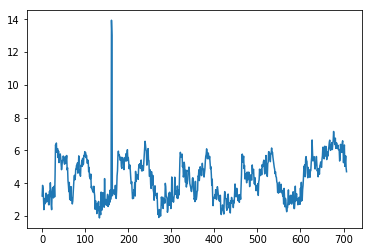

In [164]:
pred_result_set = np.array(pred_result_set).reshape(214,-1)
field = np.array(field_set).reshape(214,-1)
final_rmse = np.sqrt(np.sum((pred_result_set - field) ** 2)/field.shape[0]/field.shape[1])
print(final_rmse)

plt.plot(loss_set)
# plt.plot(mf_loss_set)
plt.show

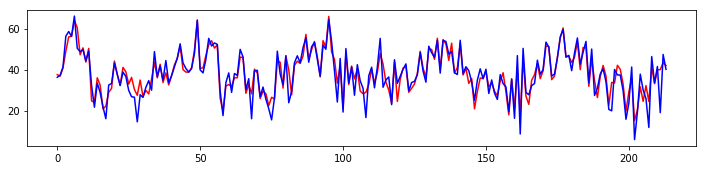

In [142]:
plt.figure(figsize = (12, 2.5))
road = 3
plt.plot(pred_result_set[:,road], 'r', field[:,road], 'b')
# plt.plot(pred_result_set[road, :]/field[road, :], 'b')
plt.show()

#### 4 Incorporate spatial variation

In [16]:
X_predict_target[:,-input_horizon:]

array([[-7.06468761e-01, -6.29576147e-01, -7.79853582e-01,
        -7.17480600e-01, -1.24194002e+00, -8.82489860e-01],
       [-6.45230055e-01, -1.07897401e+00, -1.16067445e+00,
        -1.51712716e+00, -1.31968451e+00, -1.36296213e+00],
       [ 1.08631134e-01, -1.79792363e-02, -1.18877739e-02,
         2.60698020e-01, -4.18990910e-01,  9.20277759e-02],
       [-4.39276010e-01, -3.30779165e-01, -9.47862342e-02,
        -7.97273576e-01,  2.11244938e-03, -1.58717692e-01],
       [-4.82369065e-01, -6.44657686e-02, -1.58992067e-01,
         3.56686562e-02,  4.66152698e-01,  2.62505449e-02],
       [ 1.28482640e-01,  2.73653835e-01,  6.02358937e-01,
         5.60837924e-01,  6.80345058e-01,  3.99995476e-01],
       [ 1.52272716e-01,  3.15712035e-01,  6.90686703e-01,
         7.45204508e-01,  4.29711044e-01,  2.31989965e-01],
       [ 4.84828532e-01,  8.46939385e-01,  7.54250407e-01,
         6.19884491e-01,  1.09921956e+00,  1.06722534e+00],
       [ 3.42196196e-01,  4.50036973e-01,  5.272

In [17]:
X_predict_target[:,-input_horizon:].transpose().reshape(-1,rank1*input_horizon)

array([[-7.06468761e-01, -6.45230055e-01,  1.08631134e-01,
        -4.39276010e-01, -4.82369065e-01,  1.28482640e-01,
         1.52272716e-01,  4.84828532e-01,  3.42196196e-01,
         1.35379767e+00, -6.20589435e-01,  1.85049698e-01,
         9.86742318e-01, -6.45563230e-02, -3.85608047e-01,
        -3.58667880e-01, -8.34215403e-01,  4.97323751e-01,
         3.39545012e-01, -7.46033192e-01, -5.76304018e-01,
        -7.88661122e-01, -8.88185084e-01,  3.49513888e-01,
        -1.87770844e-01,  6.87061489e-01, -5.29697418e-01,
         4.59749639e-01, -7.48209238e-01, -5.87394059e-01,
         2.24373594e-01, -5.53119838e-01, -3.75948697e-01,
        -1.16082597e+00, -7.19493985e-01,  1.11321616e+00,
        -1.25416905e-01,  4.18861955e-01, -4.06496882e-01,
         6.48363769e-01,  4.18280035e-01, -5.41673899e-01,
         1.06512940e+00,  1.08299172e+00,  5.29707253e-01,
        -1.01187611e+00, -6.80598736e-01, -7.12429225e-01,
        -6.71133935e-01, -4.56751823e-01,  1.32481635e+0

In [18]:
np.matmul(W_base,pred.reshape(-1,1))-tensor_2[:,0]

array([[ -4.97613394, -13.83413394, -17.87413394, ...,  -2.06113394,
          1.66586606, -12.90613394],
       [  4.96275842,  -3.89524158,  -7.93524158, ...,   7.87775842,
         11.60475842,  -2.96724158],
       [  6.73657739,  -2.12142261,  -6.16142261, ...,   9.65157739,
         13.37857739,  -1.19342261],
       ...,
       [ -7.54678595, -16.40478595, -20.44478595, ...,  -4.63178595,
         -0.90478595, -15.47678595],
       [ -8.91427863, -17.77227863, -21.81227863, ...,  -5.99927863,
         -2.27227863, -16.84427863],
       [  6.71656549,  -2.14143451,  -6.18143451, ...,   9.63156549,
         13.35856549,  -1.21343451]])

In [19]:
x_batch, y_batch, field_batch = generateBatch(testset, test_field_predict_set, batchsize=1, epoch=0)
    
loss_, acc_train, pred_result,field_loss_ = sess.run([model.loss, model.accuracy,model.predict, model.field_loss],
                                       feed_dict={model.bottom: x_batch, model.target: y_batch, model.spatialmatrix:W_base, model.field:field_batch})
    
print('field loss:%g'%(field_loss_))

field loss:19.1204


<function matplotlib.pyplot.show(*args, **kw)>

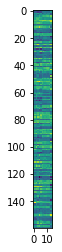

In [20]:
f = np.concatenate([X_predict_target[:,-6:],X_predict_target_validate],axis=1)
f = np.concatenate([f,pred_result.reshape(-1,1)],axis=1)
f = np.concatenate([f,pred.reshape(-1,1)],axis=1)
plt.imshow(f)
plt.show

In [21]:
np.matmul(W_base,X_predict_target_validate[:,input_horizon-1].reshape(-1,1))-field

array([[ -7.63323779, -14.80823779, -22.24923779, ..., -16.28723779,
          1.44676221,   0.51476221],
       [ 10.48271967,  -0.97028033,   5.30071967, ...,   7.10471967,
         -6.53328033,  -0.76228033],
       [  3.16183734,   4.13283734,  21.20983734, ...,  -0.08316266,
          3.82683734,  -1.60916266],
       ...,
       [  6.79383945, -12.32116055,   0.24283945, ...,  14.10283945,
          0.60583945, -14.71316055],
       [ -3.23171869,  -1.15071869,  16.40228131, ...,  -5.75771869,
          3.22928131,   1.71728131],
       [ -0.49437088,   2.64962912,   4.29962912, ...,  14.48562912,
         30.42762912,  -1.83137088]])

In [22]:
pred

array([[-0.6049516 , -0.69237363,  0.07569443, -0.4239672 ,  0.5221651 ,
         0.04363766, -0.0835541 ,  1.2640061 ,  0.7480847 ,  0.18480833,
        -0.60792655,  0.3505103 ,  0.86057246, -0.5678987 , -0.5443854 ,
        -0.678681  , -1.244878  ,  0.45218024,  0.4104744 , -0.63976365,
        -0.40601566, -0.48324245, -0.8208945 ,  0.58926034, -0.68590134,
         0.9607069 , -0.73135227,  0.7164486 , -0.7513385 , -0.63970536,
         0.27212432, -0.67610574, -0.45821676, -1.0477014 , -0.659209  ,
         0.93334574, -0.32329208,  0.78402674, -0.72374415,  0.59156334,
         0.43762258, -0.60323685,  0.5818528 ,  0.4205162 ,  0.4667931 ,
        -0.00792094, -0.34023276, -0.5091205 , -0.6871402 , -0.81656027,
         0.36495337,  0.4955625 ,  0.9255635 ,  0.41122547,  0.7037965 ,
        -0.32179123,  0.6349941 ,  0.62361145,  0.2173247 , -0.3155186 ,
        -0.3959776 ,  0.169189  , -0.6449408 ,  0.351847  , -0.7163951 ,
         0.6389827 , -0.72321045, -0.15882085, -0.6

<function matplotlib.pyplot.show(*args, **kw)>

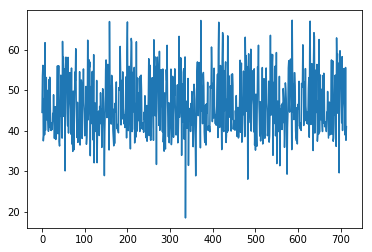

In [23]:
plt.plot(pred_result_set[0,:])
plt.show